# Notes on Semantic Image Segmentation

Nathan A. Mahynski

In [ ]:
from IPython import display

Overview

---

1. Keras has a basic starting point [here](https://keras.io/examples/vision/oxford_pets_image_segmentation/).  Here is an example of image classification [from scratch](https://keras.io/examples/vision/image_classification_from_scratch/); there are many more in the computer vision [tutorial](https://keras.io/examples/vision/) examples.
2. Tensorflow (lower level) also has examples [here](https://www.tensorflow.org/tutorials/images/segmentation).
3. An introduction to U-Net and its use in image segmentation is [here](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/).
4. [This github repo](https://github.com/divamgupta/image-segmentation-keras) has built a more user-friendly wrapper around a lot of different nets that are out there to make them easier to train and use.  It also has many nice references.

Most of these use transfer learning to re-use a convolutional base from a pre-trained network, which has a new top that is trained for a specific task.

Divam Gupta's [repo](https://github.com/divamgupta/image-segmentation-keras) provides a tool that has many pre-trained bases and top combinations that can be used out of the box.  This is an easy way to get started.

Unlike image classification, which unrolls the layers into a vector and uses a softmax to make a prediction, image segmentation uses a **fully convolutional** architecture. 

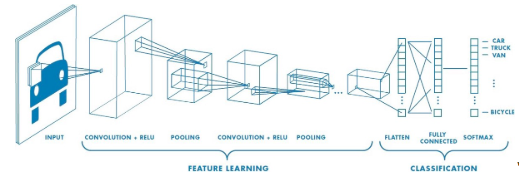

In [ ]:
display.Image("https://divamgupta.com/assets/images/posts/imgseg/image1.png", width=500)

This means the top is also made of convolutional layers so that the output of the model is another image (colored, or labeled pixel-wise) not a vector.  The bases used, however, often come from CNNs trained to do image classification; this is perfectly fine because the base just makes up the encoder part of the network (up to the bottleneck).

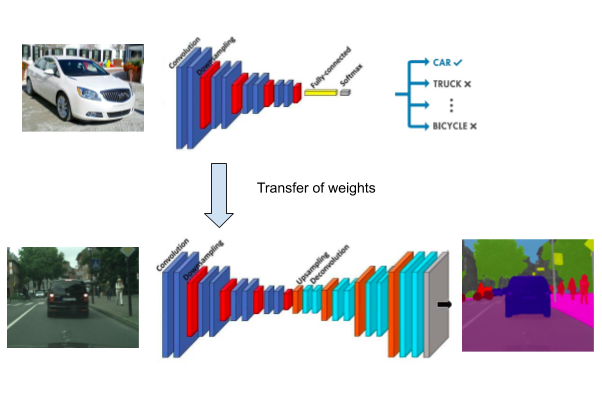

In [ ]:
display.Image("https://divamgupta.com/assets/images/posts/imgseg/image4.png", width=500)

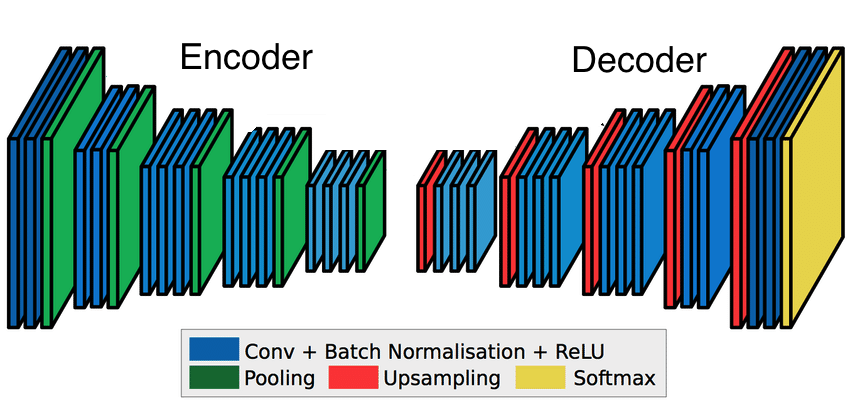

In [ ]:
# Most, but not all image segmentation networks adopt this sort of achitecture.
display.Image("https://divamgupta.com/assets/images/posts/imgseg/image5.png", width=500)

"Skip connections" help propagate low level information (needed for segmentation of local boundaries) further into the network.  This is why the "U-Net" is so popular for this task, since it follows this architecture pattern, but others can as well.

[liner.ai](https://liner.ai/) is a free tool that is very user friendly.

Types of Image segmentation:
* Semantic segmentation: classify each pixel with a label. This does NOT distinguish between multiple instances of the same object (multiple cars in the same image would be part of the same segmented/label).
* Instance segmentation: classify each pixel and differentiate each object instance.

In [ ]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
  from google.colab import drive
  drive.mount('/gdrive')
  root_dir = '/gdrive/MyDrive/Mayan EDMS/Research/Machine Learning/Colab Notebook Examples/image_segmentation'
else:
  import os
  root_dir = os.getcwd()
  !pip install keras==2.8.0 # Version notes were taken at
  
import keras
from keras import models
from keras import layers
from keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

import shutil, os

In [ ]:
!pip install watermark

In [ ]:
import watermark
%load_ext watermark

%watermark -t -m -v --iversions

# The U-Net

This is a powerful type of NN archictecture for image segmentation and other computer vision tasks.  It gets its name from the "U" shape of the connections.  Not all state-of-the-art NNs for segmentation use this architecture, but many do.

The "skip connections" between the encoder (left below) and the decoder (right below) give it its characteristic shape and help propagate information further into the network.

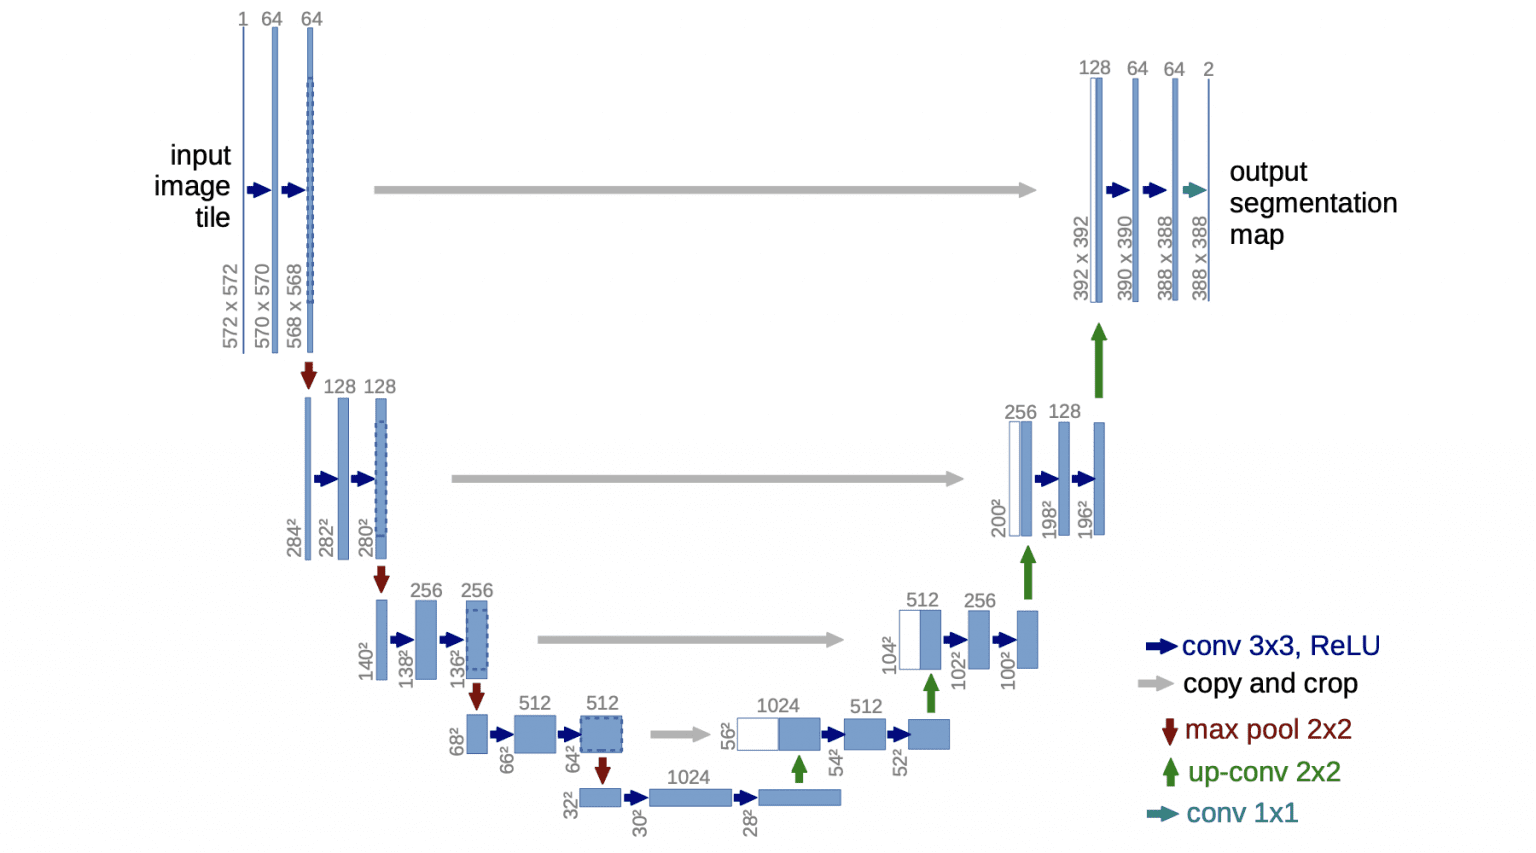

In [ ]:
display.Image("https://929687.smushcdn.com/2633864/wp-content/uploads/2022/02/1_unet_architecture_paper-1536x853.png", width=1000)

## Example U-Net from scratch

This tutorial is from [pyimagesearch.com](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/?wvideo=lrumhewyrg).

Keras has another example U-Net tutorial which uses the same dataset; see [here](https://keras.io/examples/vision/oxford_pets_image_segmentation/).

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZN33LE/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZN33LE/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

   return input_image, input_mask

In [ ]:
# Image augmentation (as discussed in Deep Learning notes)
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [ ]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [ ]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

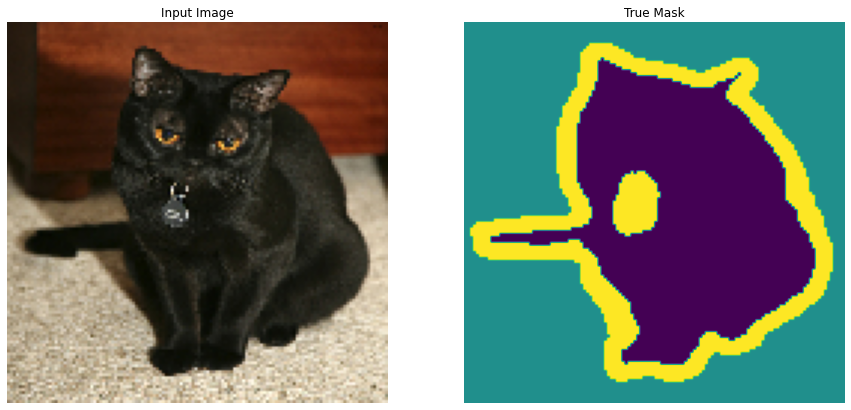

In [ ]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x

In [ ]:
# U-Net has a fairly simple architecture; however, to create the skip connections 
# between the encoder and decoder, we will need to concatenate some layers. So 
# the Keras Functional API is most appropriate for this purpose.

# First, we create a build_unet_model function, specify the inputs, encoder 
# layers, bottleneck, decoder layers, and finally the output layer with Conv2D
# with activation of softmax. Note the input image shape is 128x128x3. The 
# output has three channels corresponding to the three classes that the model 
# will classify each pixel for: background, foreground object, and object outline.

def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
 
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
 
    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
?tf.keras.utils.plot_model

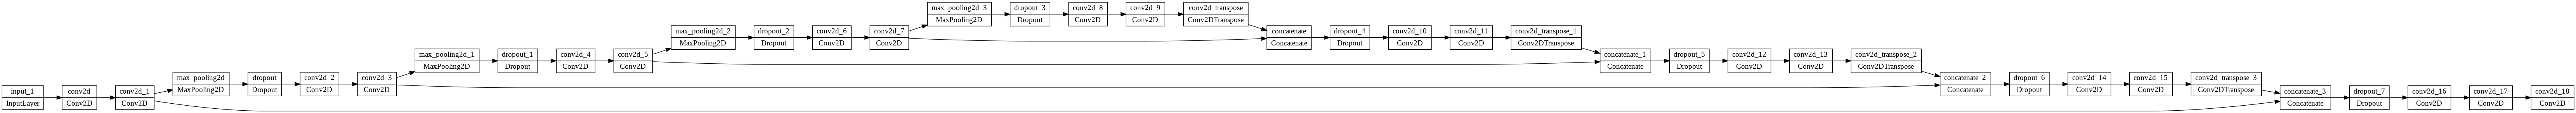

In [ ]:
tf.keras.utils.plot_model(unet_model, rankdir='LR')

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

In [ ]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)

Epoch 1/20
35/57 [=================>............] - ETA: 41:05 - loss: 1.0096 - accuracy: 0.5633

KeyboardInterrupt: ignored

In [ ]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

# Going Further

The U-Net is very powerful and popular but there are other alternatives.  This [repo](https://github.com/divamgupta/image-segmentation-keras) has made many of these more user-friendly and has a nice compilation of many different types of networks.  I'll summarize the details from there.

The full [blog post](https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html) by the author summarizing key features of the repo can be found [here](https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html).


</br>


## Some architectures:

1. FCN(8, 16, or 32) - one of the first proposed models for end-to-end semantic segmentation. This does not really follow the encoder/decoder structures used in other networks and VAEs. Here standard image classification models such as VGG and AlexNet are converted to fully convolutional nets by simply converting things into 1x1 convolutions. Transposed convolutions are used to upsample, unlike other approaches which rely on mathematical interpolations instead. This means there are learnable parameters in the upsampling stage. In FCN8 and FCN16, skip connections are used.  

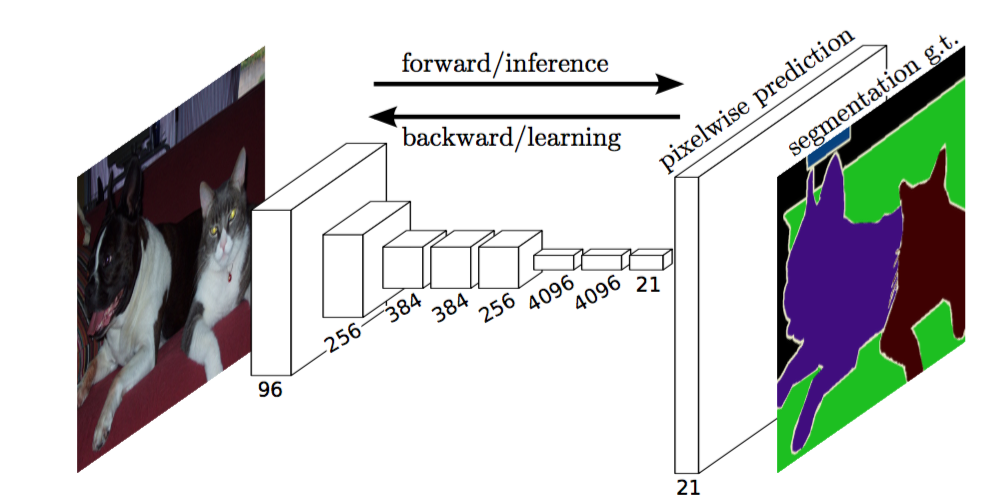

In [ ]:
display.Image("https://divamgupta.com/assets/images/posts/imgseg/image2.png", width=1000)

2. SegNet - adopts the more conventional encoder-decoder framework. The encoder and decoder layers are symmetric and the upsampling in the decoder layers use the max-pooling indices of the corresponding encoder layers. SegNet does not have any skip connections and unlike FCN, no learnable parameters are used for upsampling. However, the "memory" of the upsampling sort ot translates information through the network akin to a U-Net, just indirectly.

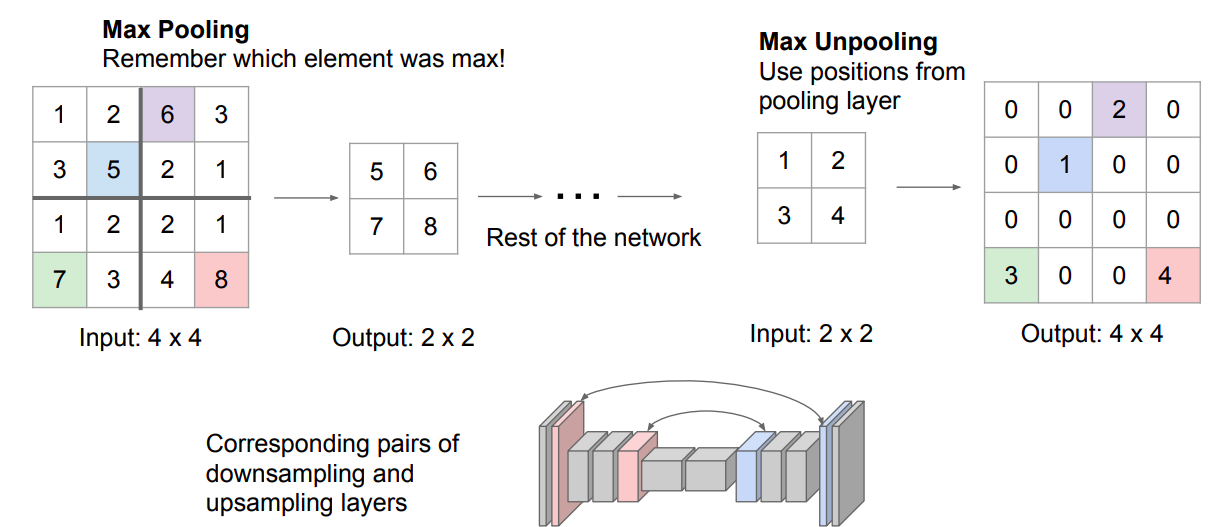

In [ ]:
display.Image("https://divamgupta.com/assets/images/posts/imgseg/image8.png", width=1000)

3. U-Net - uses an encoder-decoder framework with skip connections. Like SegNet, the encoder and decoder layers are symmetric.

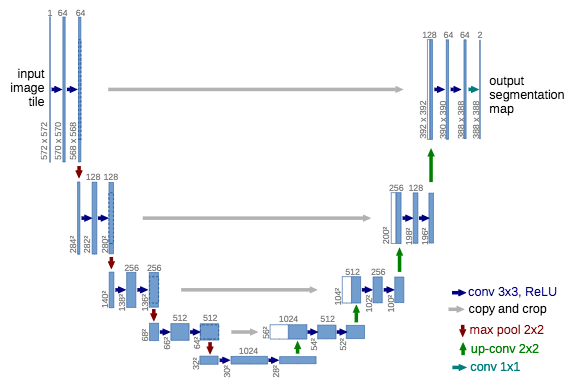

In [ ]:
display.Image("https://divamgupta.com/assets/images/posts/imgseg/image12.png", width=1000)

4. PSPNet - The Pyramid Scene Parsing Network is optimized to learn better global context representation of a scene and includes a hierarchy of scales. First, thane image is passed to the base network to get a feature map. Then it is downsampled to different scales (see image). A convolution is applied to the pooled feature maps, then all the maps are upsampled to a common scale and concatenated. Finally another convolution layer is used to produce the final segmentation. Here, the smaller objects are captured well by the features pooled to a high resolution, whereas the large objects are captured by the features pooled to a smaller size.  This is useful for segmenting patterns that have large and small objects in the image simultaneously.

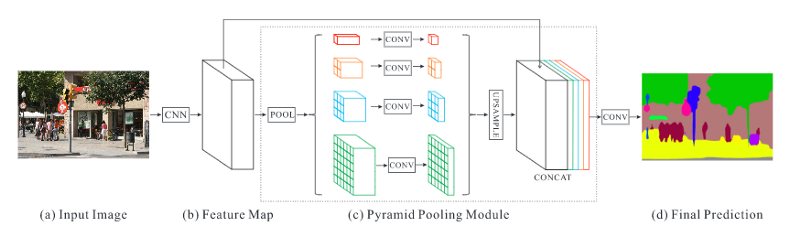

In [ ]:
display.Image("https://divamgupta.com/assets/images/posts/imgseg/image11.png", width=1000)

## Best Practices

1) Labeling 

---

For training on your own data you will need to prepare a test/train set.  To semantically label your images a number of great tools exist.

[GIMP](https://www.gimp.org/) is very general and useful, but I think [labelme](https://github.com/wkentaro/labelme) is probably easier.

Each class you want to semantically identify (0 = background, 1 = car, 2 = person, etc.) should be assigned.

2) Best Practices

---

Augmentation is a key tool to boost the amount of data your network can train on and helping to prevent overfitting.  While this can be done in Keras, for example, (or generally in python) there are some handy tools people have already made to do this easily.  For example, [imagaug](https://github.com/aleju/imgaug).

3) Determining the CNN base (encoder)

---

A standard model such as ResNet, VGG or MobileNet is usually chosen for the base encoder. For most segmentation tasks, any base network can be used, however, you should consider at least 3 different factors:

1. Number of training images; some bases are better than others with small training sets.
2. Size of the images; the bases are trained to accept images of a fixed size so you will have to work with that.  Either you need to (hopefully) downsample, or chop up your image into smaller pieces and process them individually.
3. The domain of the images; bases trained to recognize animals may be not be optimal for all segmentation tasks.

From [Divam Gupta's blog](https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html): 
> "For selecting the segmentation model, our first task is to select an appropriate base network. For many applications, choosing a model pre-trained on ImageNet is the best choice.
>
> * ResNet: This is the model proposed by Microsoft which got 96.4% accuracy in the ImageNet 2016 competition. ResNet is used as a pre-trained model for several applications. ResNet has large number of layers along with residual connections which make it’s training feasible.
> 
> * VGG-16: This is the model proposed by Oxford which got 92.7% accuracy in the ImageNet 2013 competition. Compared to Resnet it has lesser layers, hence it is much faster to train. For most of the existing segmentation benchmarks, VGG does not perform as good as ResNet in terms of accuracy. Before ResNet, VGG was the standard pre-trained model in for a large number of applications.
>
> * MobileNet: This model is proposed by Google which is optimized for having a small model size and faster inference time. This is ideal to run on mobile phones and resource-constrained devices. Due to the small size, there could be a small hit in the accuracy of the model.
>
> * Custom CNN: Apart from using an ImageNet pre-trained model, a custom network can be used as a base network. If the segmentation application is fairly simple, ImageNet pre-training is not necessary. Another advantage of using a custom base model is that we can customize it according to the application.
>
> If the domain of the images for the segmentation task is similar to ImageNet then ImageNet pre-trained models would be beneficial. For input images of indoor/ outdoor images having common objects like cars, animals, humans, etc ImageNet pre-training could be helpful. The pre-trained model can also be trained on other datasets depending on the type of input images for the task."

4) Determining the segmentation network (decoder)

---

The following advice is also from [Divam Gupta's blog](https://divamgupta.com/image-segmentation/2019/06/06/deep-learning-semantic-segmentation-keras.html): 

* For images containing indoor and outdoor scenes, PSPNet is preferred, as the objects are often present in different sizes. Here the model input size should be fairly large, something around 500x500.

* For the images in the medical domain, UNet is the popular choice. Due to the skip connections, UNet does not miss out the tiny details. UNet could also be useful for indoor/outdoor scenes with small size objects.

* For simple datasets, with large size and a small number of objects, UNet and PSPNet could be an overkill. Here simple models such as FCN or Segnet could be sufficient.

* It is best advised to experiment with multiple segmentation models with different model input sizes.